### Import dependencies

In [118]:
# !pip install tensorflow_hub

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


import tensorflow_hub as hub
import keras
from keras import Sequential, layers, models
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

### Setup data inputs

In [43]:
# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = "skintype-data/train/"
test_dir = "skintype-data/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)
test_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 175 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


In [44]:
# Class labels

import pathlib 
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['normal_skin' 'oily_skin']


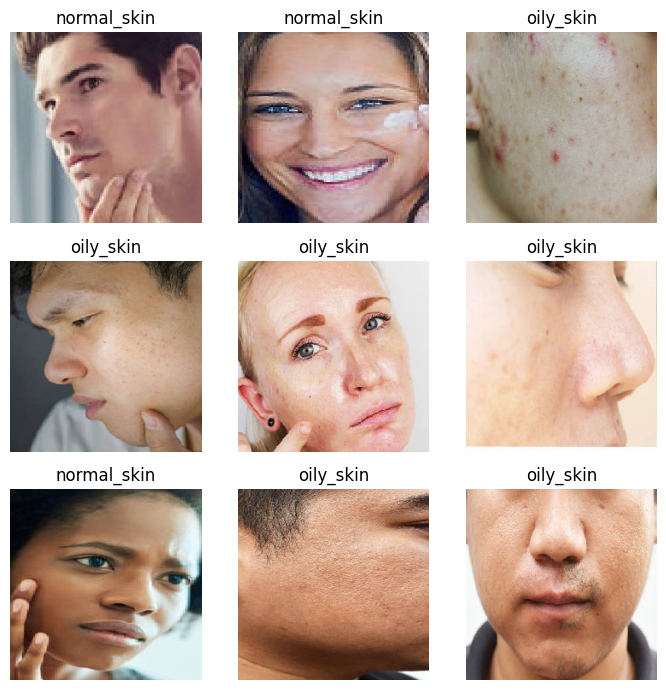

In [46]:
# Display images from train_data
plt.figure(figsize=(7, 7))
for images, labels in train_data:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        ax.imshow(images[i])
        ax.set_title(class_names[labels[i].argmax()])
        ax.axis("off")

    if i == 8:
        break

plt.tight_layout()
plt.show()

### Build Keras sequential model with a pretrained model(EfficientNet-B0 architecture) as the feature extractor

See more on transfer learning with <a href="https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub">Tensorflow Hub</a>.

In [25]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

IMAGE_SHAPE = (600, 600)
BATCH_SIZE = 32

def create_model(model_url, num_classes=2):
  """ Take a TensorFlow Hub URL and creates a Keras Sequential model with it.  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,   # freeze the already learned patterns
                                           name="EfficientnetB0_model",
                                           input_shape=IMAGE_SHAPE+(3,))  # define the input image shape
  # Create the image model
  model = Sequential([
    feature_extractor_layer,    # use the feature extraction layer as the base
    layers.Dense(num_classes, activation="sigmoid", name="output_layer")   # create our own output layer
  ])
  return model

In [33]:
# Create EfficientNet model (using Transfer learning from The EfficientNet-B0 architecture)
efficientnet_model = create_model(efficientnet_url,
                            num_classes=2)
# Compile
efficientnet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                     optimizer=keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [34]:
efficientnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EfficientnetB0_model (Keras  (None, 1280)             4049564   
 Layer)                                                          
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 2,562
Non-trainable params: 4,049,564
_________________________________________________________________


In [35]:
# Fit the model
# STEP_SIZE_TRAIN=train_data.n//train_data.batch_size
# STEP_SIZE_VALID=test_data.n//test_data.batch_size
# efficientnet_model.fit(train_data,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=test_data,
#                     validation_steps=STEP_SIZE_VALID,
#                     epochs=5
# )

efficientnet_history = efficientnet_model.fit(train_data,
    validation_data=test_data,
    epochs=5
)
    
                      

Epoch 1/5


c:\Users\Daniella0\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


6/6 [==============================] - 34s 3s/step - loss: 0.5995 - accuracy: 0.8114 - val_loss: 0.5150 - val_accuracy: 0.8846
Epoch 2/5
6/6 [==============================] - 16s 3s/step - loss: 0.4829 - accuracy: 0.8971 - val_loss: 0.4536 - val_accuracy: 0.8654
Epoch 3/5
6/6 [==============================] - 16s 3s/step - loss: 0.4185 - accuracy: 0.8857 - val_loss: 0.4076 - val_accuracy: 0.8846
Epoch 4/5
6/6 [==============================] - 15s 3s/step - loss: 0.3674 - accuracy: 0.8914 - val_loss: 0.3747 - val_accuracy: 0.8654
Epoch 5/5
6/6 [==============================] - 16s 3s/step - loss: 0.3286 - accuracy: 0.9086 - val_loss: 0.3538 - val_accuracy: 0.8654


In [36]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions for the test data
y_pred = efficientnet_model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_data.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate precision, recall, and F1 score
report = classification_report(y_true, y_pred, target_names=class_names)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


2/2 [==============================] - 5s 1s/step
Confusion Matrix:
[[14 12]
 [13 13]]

Classification Report:
              precision    recall  f1-score   support

 normal_skin       0.52      0.54      0.53        26
   oily_skin       0.52      0.50      0.51        26

    accuracy                           0.52        52
   macro avg       0.52      0.52      0.52        52
weighted avg       0.52      0.52      0.52        52



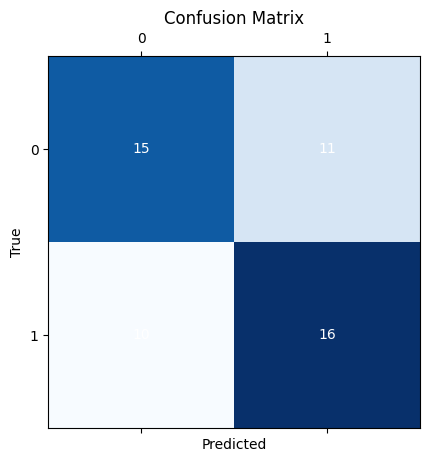

In [11]:
# Import the necessary modules
import matplotlib.pyplot as plt
import numpy as np

# Create the confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.matshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Add the number of predictions to each box
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", verticalalignment="center", color="white")

plt.show()


In [39]:
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

 normal_skin       0.52      0.54      0.53        26
   oily_skin       0.52      0.50      0.51        26

    accuracy                           0.52        52
   macro avg       0.52      0.52      0.52        52
weighted avg       0.52      0.52      0.52        52



In [9]:
efficientnet_model.save('../models/Skintype-Model2')

INFO:tensorflow:Assets written to: ../models/Skintype-Model2\assets


INFO:tensorflow:Assets written to: ../models/Skintype-Model2\assets


In [4]:
model = models.load_model('../models/Skintype-Model')

# Check the architecture of the loaded model
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EfficientnetB0_model (Keras  (None, 1280)             4049564   
 Layer)                                                          
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 2,562
Non-trainable params: 4,049,564
_________________________________________________________________


In [10]:
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_data.classes

2/2 [==============================] - 5s 964ms/step


In [13]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names)

In [14]:
cm


array([[14, 12],
       [14, 12]], dtype=int64)

In [15]:
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

 normal_skin       0.50      0.54      0.52        26
   oily_skin       0.50      0.46      0.48        26

    accuracy                           0.50        52
   macro avg       0.50      0.50      0.50        52
weighted avg       0.50      0.50      0.50        52



In [5]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """ Reads in an image from filename, turns it into a tensor and reshapes into (224,224,3). """
  
  # Read in the image and decode it into a tensor
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img)
    
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [8]:
def pred_and_plot(model, filename, class_names=class_names):
  """
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred[0]))]
  
  print('Prediction Probabilities : ', pred[0])

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Predicted skintype: {pred_class}")
  plt.axis(False)

1/1 [==============================] - 0s 92ms/step
Prediction Probabilities :  [0.12001417 0.8847004 ]


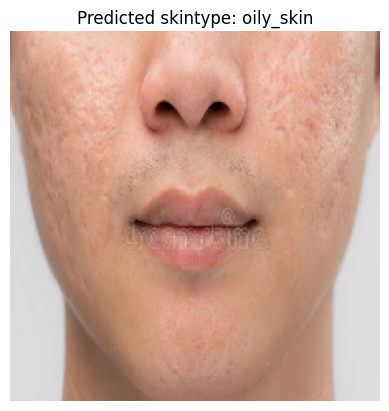

In [42]:
# Test model on oily skin
pred_and_plot(model=model, 
              filename="skintype-data/test/oily_skin/c129.jpeg", 
              class_names=class_names)

1/1 [==============================] - 0s 94ms/step
Prediction Probabilities :  [0.5546787  0.38871115]


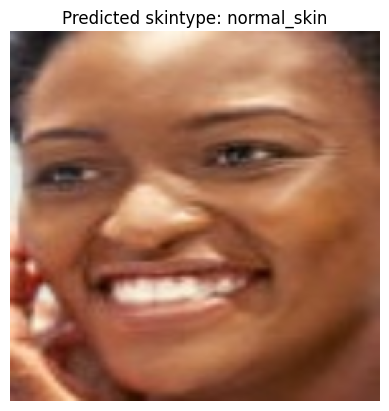

In [43]:
# Test model on normal skin
pred_and_plot(model=model, 
              filename="skintype-data/test/normal_skin/c116.jpeg", 
              class_names=class_names)

1/1 [==============================] - 0s 93ms/step
Prediction Probabilities :  [0.4517328 0.6397822]


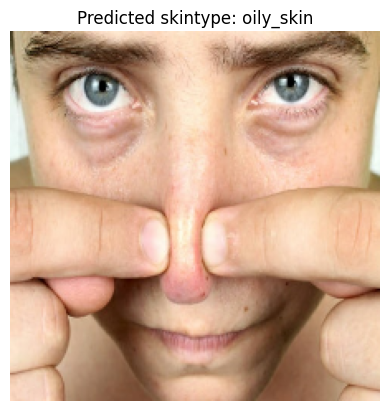

In [50]:
# Test model on normal skin
pred_and_plot(model=model, 
              filename="skintype-data/test/oily_skin/c8.jpeg", 
              class_names=class_names)